
Number of image files: 30
Number of json files: 30


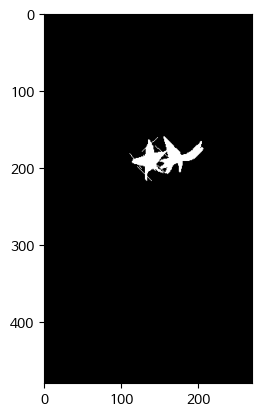

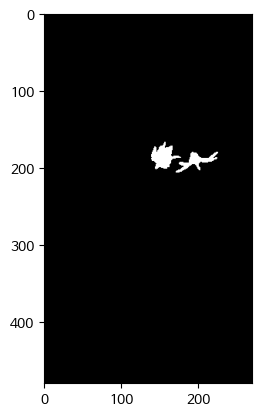

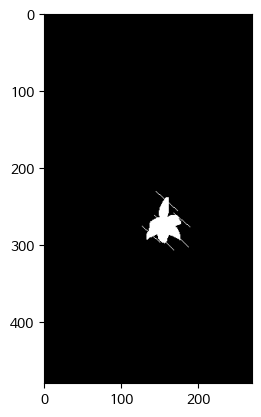

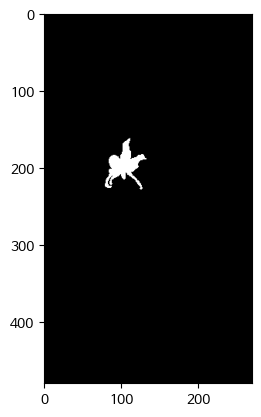

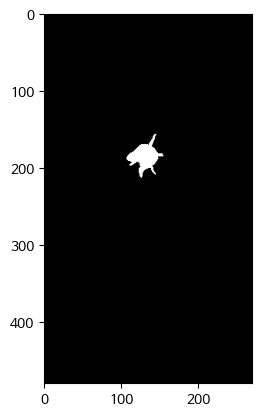

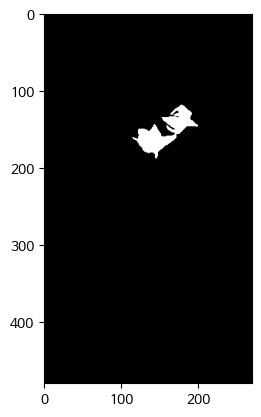

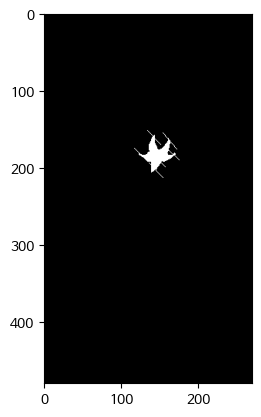

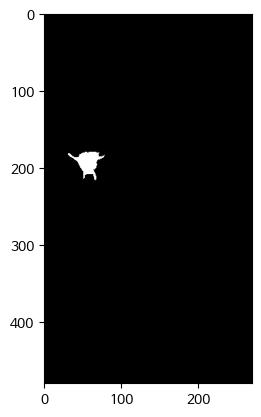

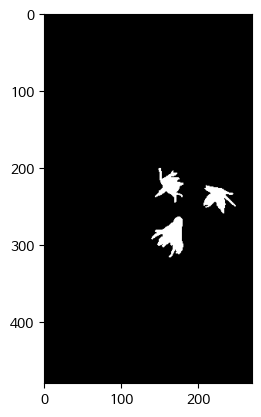

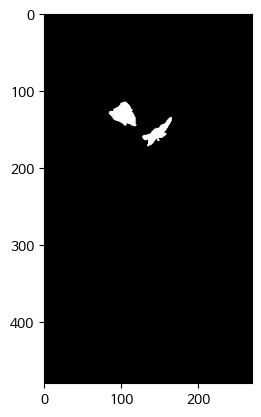

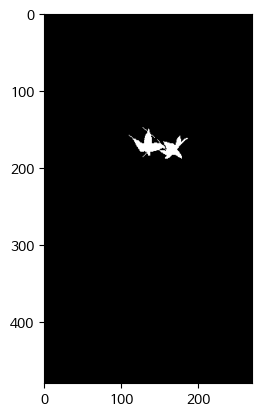

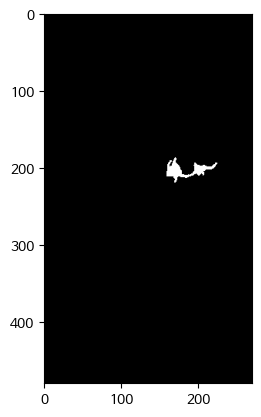

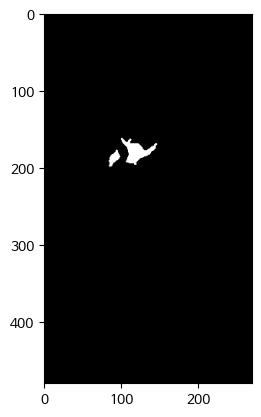

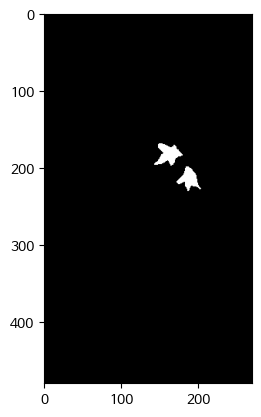

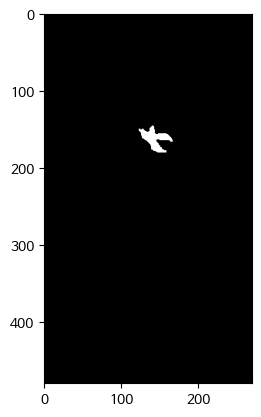

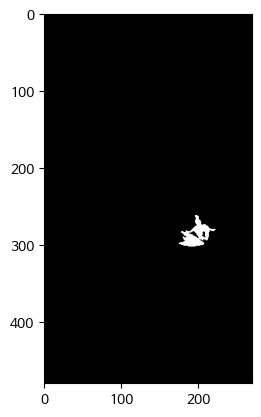

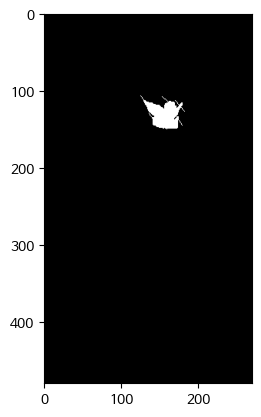

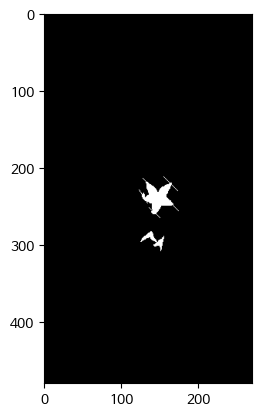

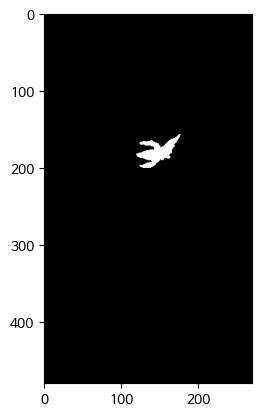

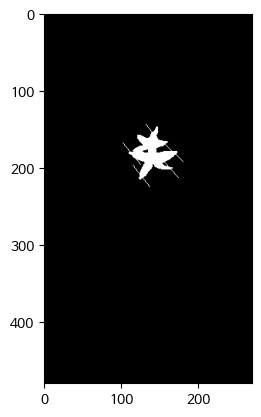

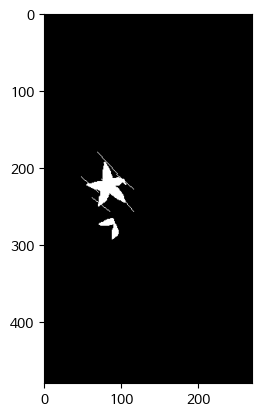

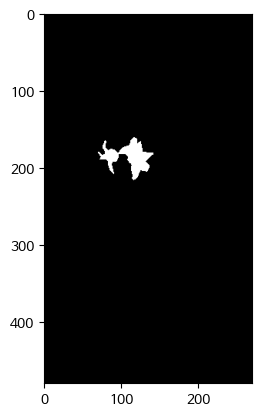

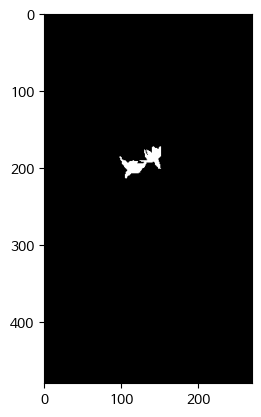

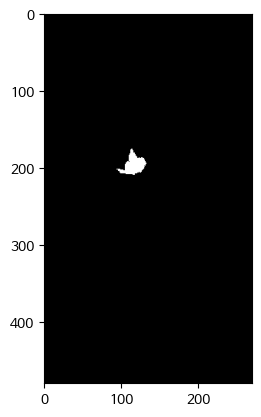

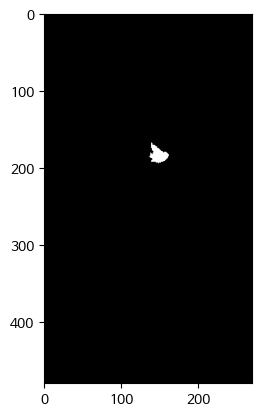

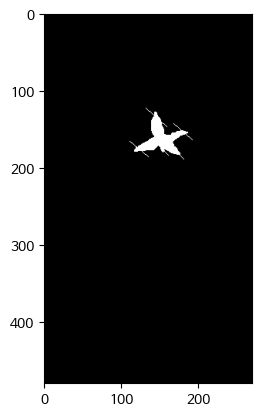

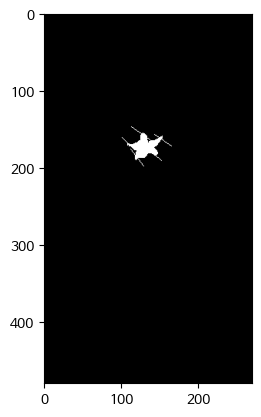

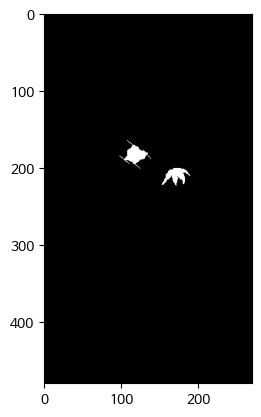

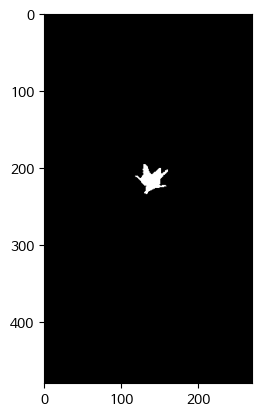

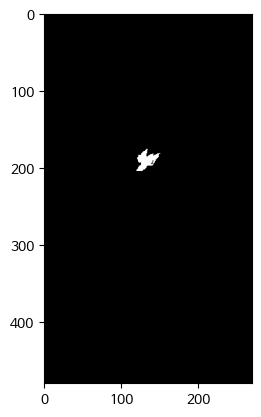

In [1]:
import cv2
import json
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Dropout,BatchNormalization, Activation
from tensorflow.keras.models import Model
from skimage.transform import resize
from keras.layers import Conv2DTranspose
from keras.preprocessing.image import img_to_array, load_img




img_directory = 'E:\\Unet\\만개꽃_축소이미지'
json_directory = 'E:\\Unet\\만개꽃_축소JSON'

image_files = [os.path.join(img_directory, file) for file in os.listdir(img_directory) if file.endswith('.png')][:30]
json_files = [os.path.join(json_directory, file.replace('.png', '.json')) for file in os.listdir(img_directory) if file.endswith('.png')][:30]

print(f"Number of image files: {len(image_files)}")
print(f"Number of json files: {len(json_files)}")

for image_file, json_file in zip(image_files, json_files):
    image = Image.open(image_file)
    image = np.array(image)

    if image is None:
        print(f"Cannot load image: {image_file}")
        continue

    with open(json_file, 'r') as f:
        data = json.load(f)

    original_size = (data['imageWidth'], data['imageHeight'])

    # 세그멘테이션 이미지 초기화 (모든 픽셀 값이 0인 이미지)
    segmentation = np.zeros((original_size[1], original_size[0]), dtype=np.uint8)

    shapes = data['shapes']
    
    # points로 가져온 좌표 안쪽은 모두 1로 라벨링 하는 코드
    for shape in shapes:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(segmentation, [points], 1)
    
    # 
    new_image_path = os.path.join("E:/Unet/만개꽃/", os.path.split(image_file)[1].replace('.png', '_seg.png'))

    img_pil = Image.fromarray(segmentation * 255)  # 0과 1로 이루어진 이미지를 0과 255로 변환
    img_pil.save(new_image_path)

    # 세그멘테이션 이미지를 화면에 출력
    plt.imshow(segmentation, cmap='gray')
    plt.show()


In [2]:
def ConvBlock(filters, inputs):
    x = Conv2D(filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [3]:
def create_model(input_shape):
    inputs = Input(input_shape)

    conv1 = ConvBlock(64, inputs)
    drop1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = ConvBlock(128, pool1)
    drop2 = Dropout(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = ConvBlock(256, pool2)
    drop3 = Dropout(0.2)(conv3)

    # Bridge
    bridge = ConvBlock(512, drop3)

    up4 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(bridge)
    merge4 = concatenate([drop2, up4], axis=3)
    conv4 = ConvBlock(128, merge4)
    drop4 = Dropout(0.2)(conv4)

    up5 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(drop4)
    merge5 = concatenate([drop1, up5], axis=3)
    conv5 = ConvBlock(64, merge5)
    drop5 = Dropout(0.2)(conv5)

    conv6 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop5)
    conv7 = Conv2D(1, 1, activation='sigmoid')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    return model



In [5]:
img_directory = 'E:\\Unet\\만개꽃_축소이미지'
json_directory = 'E:\\Unet\\만개꽃_축소JSON'

image_files = [os.path.join(img_directory, file) for file in os.listdir(img_directory) if file.endswith('.png')]
json_files = [os.path.join(json_directory, file.replace('.png', '.json')) for file in os.listdir(img_directory) if file.endswith('.png')]

# 학습 데이터와 테스트 데이터로 나누는 부분
image_train_files = image_files[:24]
json_train_files = json_files[:24]
image_test_files = image_files[-6:]
json_test_files = json_files[-6:]

# 이미지와 세그멘테이션 레이블의 크기를 조정할 크기
target_size = (480, 272)

def load_data(image_files, json_files, target_size):
    images = []
    labels = []

    for image_file, json_file in zip(image_files, json_files):
        # 이미지 로드
        image = load_img(image_file, target_size=target_size)
        image = img_to_array(image)

        # 세그멘테이션 레이블 로드
        with open(json_file, 'r') as f:
            data = json.load(f)
        original_size = (data['imageWidth'], data['imageHeight'])
        segmentation = np.zeros((original_size[1], original_size[0]), dtype=np.uint8)
        shapes = data['shapes']
        for shape in shapes:
            points = np.array(shape['points'], dtype=np.int32)
            cv2.fillPoly(segmentation, [points], 1)

        # 세그멘테이션 레이블 크기 조정
        segmentation = resize(segmentation, target_size, mode='constant', preserve_range=True)

        images.append(image)
        labels.append(segmentation)

    # numpy array로 변환
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# 학습 데이터 로드
x_train, y_train = load_data(image_train_files, json_train_files, target_size)

# 학습 데이터를 평가하는 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 테스트 데이터 로드
x_test, y_test = load_data(image_test_files, json_test_files, target_size)


In [ ]:
# 첫 번째 테스트 이미지를 가져옵니다.
test_image = y_train[6]

# 이미지를 시각화합니다.
plt.imshow(test_image)
plt.show()

In [ ]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

In [ ]:
# 모델 생성
input_shape = (480, 272, 3)  # 실제 이미지의 크기
model = create_model(input_shape=input_shape)  # 실제 이미지 크기에 맞게 모델 생성

# 모델 컴파일
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, batch_size=8, epochs=5, validation_data=(x_val, y_val))

# 모델 저장
model.save('unet_model.h5')

In [ ]:
# 모델 평가
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {acc}")

# 모델 예측
predictions = model.predict(x_test)

In [ ]:
test_image2 = y_test[2]

# 이미지를 시각화합니다.
plt.imshow(test_image2)
plt.show()

In [ ]:
# 예측 결과 시각화
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_test[2] / 255.0)        # 원본 이미지
ax[0].set_title("Input Image")
ax[1].imshow(predictions[2].squeeze(), cmap='gray')  # 예측된 세그멘테이션 결과
ax[1].set_title("Predicted Segmentation")
plt.show()

In [ ]:
# 결과를 확인하기 위해 작성한 코드
print(predictions[2])

In [ ]:
print(predictions[2].shape)